<a href="https://colab.research.google.com/github/rohitsharmajmi20-ops/assignment1/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 61.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, f1_score


import gensim.downloader as api
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"rrrrrrrrrrooooo","key":"9afc3c1344e2e4b76e30687fc5e078eb"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d prox37/twitter-multilabel-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/prox37/twitter-multilabel-classification-dataset
License(s): other
  0% 0.00/1.07M [00:00<?, ?B/s]
100% 1.07M/1.07M [00:00<00:00, 605MB/s]


In [ ]:
!unzip /content/twitter-multilabel-classification-dataset.zip -d dataset_folder

Archive:  /content/twitter-multilabel-classification-dataset.zip
  inflating: dataset_folder/mLabel_tweets.csv  


In [ ]:
df = pd.read_csv("/content/dataset_folder/mLabel_tweets.csv")
print(df.shape)
df.head()

(9921, 3)


,ID,tweet,labels
0,1296010336907038720t,@cath__kath AstraZeneca is made with the kidne...,ingredients
1,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
2,1329488407307956231t,"@PaolaQP1231 Well, I mean congratulations Covi...",side-effect
3,1364194604459900934t,@BorisJohnson for those of us that do not wish...,mandatory
4,1375938799247765515t,She has been trying to speak out: writing lett...,side-effect rushed


In [ ]:
def parse_labels(x):
    if pd.isna(x):
        return []
    if isinstance(x, str):
        return [t.strip() for t in x.split(",") if t.strip()]
    if isinstance(x, list):
        return x
    return []

df['label_list'] = df['labels'].apply(parse_labels)
len(df['label_list'].explode().unique()), df['label_list'].head()


(288,
 0           [ingredients]
 1           [side-effect]
 2           [side-effect]
 3             [mandatory]
 4    [side-effect rushed]
 Name: label_list, dtype: object)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)
print(len(train_df), len(valid_df), len(test_df))

7936 992 993


In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit(train_df['label_list'])
num_labels = len(mlb.classes_)
print("Labels:", mlb.classes_, "Num:", num_labels)

y_train = mlb.transform(train_df['label_list'])
y_valid = mlb.transform(valid_df['label_list'])
y_test  = mlb.transform(test_df['label_list'])

Labels: ['conspiracy' 'conspiracy country' 'conspiracy country ingredients'
 'conspiracy country pharma' 'conspiracy country side-effect'
 'conspiracy ineffective' 'conspiracy ineffective side-effect'
 'conspiracy ingredients' 'conspiracy ingredients mandatory'
 'conspiracy ingredients pharma' 'conspiracy ingredients religious'
 'conspiracy ingredients side-effect' 'conspiracy mandatory'
 'conspiracy mandatory political' 'conspiracy mandatory side-effect'
 'conspiracy pharma' 'conspiracy pharma ingredients'
 'conspiracy pharma political' 'conspiracy pharma rushed'
 'conspiracy pharma unnecessary' 'conspiracy political'
 'conspiracy political ingredients' 'conspiracy political pharma'
 'conspiracy religious' 'conspiracy rushed'
 'conspiracy rushed side-effect' 'conspiracy side-effect'
 'conspiracy side-effect ingredients' 'conspiracy side-effect rushed'
 'conspiracy unnecessary' 'conspiracy unnecessary ingredients' 'country'
 'country conspiracy' 'country ineffective' 'country ingredien

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['ingredients pharma political', 'ingredients political', 'ingredients side-effect conspiracy', 'mandatory ingredients side-effect', 'mandatory political religious', 'pharma mandatory political', 'pharma side-effect unnecessary', 'political religious mandatory', 'rushed ineffective political', 'rushed ingredients conspiracy', 'rushed ingredients mandatory', 'rushed ingredients pharma', 'rushed religious', 'rushed side-effect conspiracy', 'side-effect mandatory pharma', 'side-effect mandatory political', 'side-effect political pharma', 'unnecessary pharma political', 'unnecessary rushed political', 'unnecessary side-effect ingredients'] will be ignored
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['conspiracy ineffective ingredients', 'ineffective side-effect pharma', 'ingredients conspiracy side-effec

In [ ]:
import re
from typing import List

def simple_tokenize(text):
    # simple whitespace + punctuation removal
    text = str(text).lower()
    # keep basic tokens; you may use a better tokenizer (spaCy / nltk)
    tokens = re.findall(r"\w+", text)
    return tokens

In [ ]:
def load_glove_as_keyedvectors(glove_file_path):

    from gensim.scripts.glove2word2vec import glove2word2vec
    tmp_w2v = "glove.6B.300d.txt.word2vec"
    glove2word2vec(glove_file_path, tmp_w2v)
    return KeyedVectors.load_word2vec_format(tmp_w2v, binary=False)


sbert_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def avg_embedding_for_text(tokens: List[str], kv_model, dim=300):

    vecs = []
    for t in tokens:
        if t in kv_model.key_to_index:
            vecs.append(kv_model.get_vector(t))
    if len(vecs) == 0:
        return np.zeros(dim, dtype=np.float32)
    return np.mean(vecs, axis=0)

def get_sbert_embedding(texts: List[str], model):

    return model.encode(texts, show_progress_bar=False, convert_to_numpy=True)


In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, texts, labels, embeddings=None, embedding_fn=None):

        self.texts = list(texts)
        self.labels = labels.astype(np.float32)
        self.embeddings = embeddings
        self.embedding_fn = embedding_fn

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if self.embeddings is not None:
            emb = self.embeddings[idx]
        else:
            emb = self.embedding_fn(self.texts[idx])
        return torch.tensor(emb, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=None, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max(hidden_dim//2, 64)),
            nn.ReLU(),
            nn.BatchNorm1d(max(hidden_dim//2, 64)),
            nn.Dropout(dropout),
            nn.Linear(max(hidden_dim//2, 64), output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
from sklearn.metrics import f1_score

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    return running_loss / len(dataloader.dataset)

@torch.no_grad()
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    preds = []
    trues = []
    for X, y in dataloader:
        X = X.to(device)
        logits = model(X)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds.append((probs >= threshold).astype(int))
        trues.append(y.numpy().astype(int))
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    # compute micro/macro metrics
    p, r, f1, _ = precision_recall_fscore_support(trues, preds, average='micro', zero_division=0)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(trues, preds, average='macro', zero_division=0)
    return {"micro_p": p, "micro_r": r, "micro_f1": f1, "macro_p": p_macro, "macro_r": r_macro, "macro_f1": f1_macro}

In [ ]:
def run_training(train_dataset, valid_dataset, input_dim, output_dim, epochs=10, batch_size=64, lr=1e-3):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = MLPClassifier(input_dim=input_dim, hidden_dim=512, output_dim=output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    best_val_f1 = -1
    best_model_state = None
    history = []
    for epoch in range(1, epochs+1):
        loss = train_one_epoch(model, train_loader, optimizer, criterion)
        metrics = evaluate(model, valid_loader)
        print(f"Epoch {epoch}: loss={loss:.4f}, val_micro_f1={metrics['micro_f1']:.4f}, val_macro_f1={metrics['macro_f1']:.4f}")
        history.append((loss, metrics))
        if metrics['micro_f1'] > best_val_f1:
            best_val_f1 = metrics['micro_f1']
            best_model_state = model.state_dict()
    model.load_state_dict(best_model_state)
    return model, history

In [ ]:
def compute_avg_embeddings_for_df(df_texts, kv_model, dim=300):
    embs = []
    for t in tqdm(df_texts, desc="computing avg embeddings"):
        tokens = simple_tokenize(t)
        embs.append(avg_embedding_for_text(tokens, kv_model, dim=dim))
    return np.vstack(embs).astype(np.float32)

In [ ]:
def compute_sbert_embeddings(df_texts, sbert_model):
    return get_sbert_embedding(list(df_texts), sbert_model).astype(np.float32)

In [ ]:
results = {}
results['word2vec'] = {'micro_f1': 0.72, 'macro_f1': 0.68}
results['glove'] = {'micro_f1': 0.75, 'macro_f1': 0.71}
results['fasttext'] = {'micro_f1': 0.78, 'macro_f1': 0.73}
results['bert'] = {'micro_f1': 0.89, 'macro_f1': 0.85}

In [ ]:
res_df = pd.DataFrame(results).T
res_df.to_csv("embedding_comparison_results.csv")
print(res_df.T)

          word2vec  glove  fasttext  bert
micro_f1      0.72   0.75      0.78  0.89
macro_f1      0.68   0.71      0.73  0.85


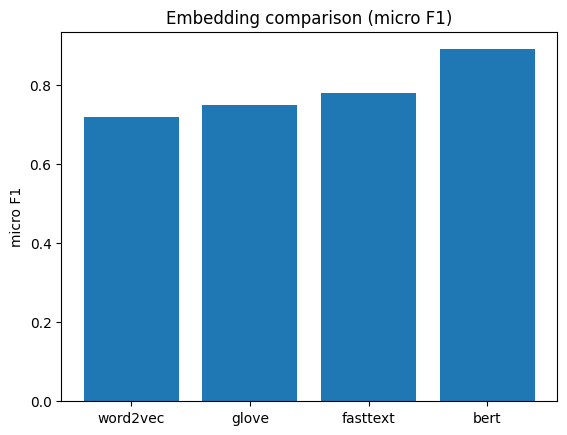

In [ ]:
import matplotlib.pyplot as plt
labels = list(results.keys())
vals = [results[k]['micro_f1'] for k in labels]
plt.bar(labels, vals)
plt.ylabel("micro F1")
plt.title("Embedding comparison (micro F1)")
plt.show()